# Testing The Model

## Config

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("takihasan/div2k-dataset-for-super-resolution")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/div2k-dataset-for-super-resolution


In [2]:
!ls /kaggle/input/div2k-dataset-for-super-resolution/Dataset

DIV2K_train_HR		DIV2K_train_LR_bicubic_X4  DIV2K_valid_LR_bicubic
DIV2K_train_LR_bicubic	DIV2K_valid_HR		   DIV2K_valid_LR_bicubic_X4


In [3]:
TEST_DIR = "/kaggle/input/div2k-dataset-for-super-resolution/Dataset/DIV2K_valid_HR"

import os
import numpy as np
from torchvision import transforms
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# models.py
import torch
from torch import nn

class ResidualBlock(nn.Module):
    """
    A single residual block as defined in the SRGAN paper.
    It contains two convolutional layers with batch normalization and PReLU activation.
    """
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return identity + out

class UpsampleBlock(nn.Module):
    """
    Upsampling block using a convolutional layer and PixelShuffle.
    This increases the resolution by a factor of 2.
    """
    def __init__(self, in_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (scale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        return self.prelu(self.pixel_shuffle(self.conv(x)))

class Generator(nn.Module):
    """
    The Generator Network (SRResNet).
    It takes a low-resolution image and outputs a super-resolved version.
    """
    def __init__(self, in_channels=3, num_res_blocks=16):
        super(Generator, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_res_blocks)])

        self.mid_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        # Upsampling by 4x (two 2x upsample blocks)
        self.upsample_blocks = nn.Sequential(
            UpsampleBlock(64),
            UpsampleBlock(64),
        )

        self.final_conv = nn.Conv2d(64, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial_out = self.initial_conv(x)
        residual_out = self.residuals(initial_out)
        mid_out = self.mid_conv(residual_out)
        mid_out = mid_out + initial_out # Skip connection
        upsampled_out = self.upsample_blocks(mid_out)
        final_out = self.final_conv(upsampled_out)
        return torch.tanh(final_out) # Tanh activation to scale output to [-1, 1]

class Discriminator(nn.Module):
    """
    The Discriminator Network.
    It takes an image and outputs a probability of it being a real high-resolution image.
    """
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def conv_block(in_feat, out_feat, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_feat),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(64, 64, stride=2),
            conv_block(64, 128, stride=1),
            conv_block(128, 128, stride=2),
            conv_block(128, 256, stride=1),
            conv_block(256, 256, stride=2),
            conv_block(256, 512, stride=1),
            conv_block(512, 512, stride=2),
        )

        # The paper mentions flattening and then two dense layers
        # The output size after convolutions on a 96x96 image is 512x6x6
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Flattens the output
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        out = self.blocks(x)
        out = self.classifier(out)
        return out.view(batch_size, -1) # No sigmoid here, handled by BCEWithLogitsLoss

In [5]:
from huggingface_hub import hf_hub_download

# Hugging Face model configuration
HF_MODEL_NAME = "keanteng/srgan-div2k-0723-v2"  # Your model name from srgan.ipynb

# Download the generator model
GEN_PATH = hf_hub_download(
    repo_id=HF_MODEL_NAME,
    filename="generator.pth"
)

print(f"Downloaded model to: {GEN_PATH}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


generator.pth:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

Downloaded model to: /root/.cache/huggingface/hub/models--keanteng--srgan-div2k-0723-v2/snapshots/f2e47c2f6b75a6c7b775b28ee252c91ecbb43cd6/generator.pth


## Inference

In [6]:
# evaluate.py
from torchvision.utils import save_image
from torchvision import transforms
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
#import config
#from models import Generator

def calculate_psnr(img1, img2):
    """
    Calculate PSNR between two images.
    Images should be in range [0, 255] and of type uint8.
    """
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")

    mse = np.mean((img1.astype(np.float64) - img2.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')

    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def calculate_ssim(img1, img2):
    """
    Calculate SSIM between two images.
    Images should be in range [0, 255] and of type uint8.
    """
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert to grayscale if images are color
    if len(img1.shape) == 3:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        img1_gray = img1
        img2_gray = img2

    ssim_value = ssim(img1_gray, img2_gray, data_range=255)
    return ssim_value

def tensor_to_numpy(tensor):
    """
    Convert tensor to numpy array in range [0, 255].
    """
    # Denormalize from [-1, 1] to [0, 1]
    tensor = tensor * 0.5 + 0.5
    # Clamp to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    # Convert to numpy and scale to [0, 255]
    numpy_img = tensor.squeeze(0).cpu().detach().numpy()
    numpy_img = np.transpose(numpy_img, (1, 2, 0))  # CHW to HWC
    numpy_img = (numpy_img * 255).astype(np.uint8)
    return numpy_img

In [ ]:
def rgb_to_y_channel(img):
    """Convert RGB image to Y channel (luminance)"""
    if len(img.shape) == 3:
        # ITU-R BT.601 conversion
        y = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
        return y.astype(np.uint8)
    return img

def calculate_metrics_paper_protocol(img1, img2):
    """
    Calculate PSNR and SSIM following the original SRGAN paper protocol
    """
    # Convert to Y channel
    y1 = rgb_to_y_channel(img1)
    y2 = rgb_to_y_channel(img2)
    
    # Remove 4-pixel border (center crop)
    h, w = y1.shape
    y1_cropped = y1[4:h-4, 4:w-4]
    y2_cropped = y2[4:h-4, 4:w-4]
    
    # Calculate metrics on Y channel only
    psnr_val = calculate_psnr(y1_cropped, y2_cropped)
    ssim_val = ssim(y1_cropped, y2_cropped, data_range=255)
    
    return psnr_val, ssim_val

In [14]:
def test_original_full_resolution(image_path, save_prefix="full_res"):
    """
    Test the model on an original image at full resolution.
    Creates LR by downsampling the full original image, adjusting dimensions to be divisible by 4.
    """
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_width, original_height = original_image.size

    print(f"Original image size: {original_width} x {original_height}")

    # Ensure dimensions are divisible by 4 (due to 4x upscaling)
    adjusted_width = (original_width // 4) * 4
    adjusted_height = (original_height // 4) * 4

    if adjusted_width != original_width or adjusted_height != original_height:
        adjusted_image = original_image.resize((adjusted_width, adjusted_height), Image.BICUBIC)
        print(f"Adjusted original to: {adjusted_width} x {adjusted_height}")
    else:
        adjusted_image = original_image

    # Create LR version by downsampling the adjusted image by 4x
    lr_width = adjusted_width // 4
    lr_height = adjusted_height // 4
    lr_image = adjusted_image.resize((lr_width, lr_height), Image.BICUBIC)

    print(f"LR input size: {lr_width} x {lr_height}")
    print(f"Expected SR output size: {adjusted_width} x {adjusted_height}")

    # Convert to tensor and normalize
    lr_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ])
    lr_tensor = lr_transform(lr_image).unsqueeze(0).to(DEVICE)

    # Generate SR image
    gen = Generator().to(DEVICE)
    gen.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
    gen.eval()

    print("Generating super-resolution image...")
    with torch.no_grad():
        sr_tensor = gen(lr_tensor)

    print(f"SR tensor shape: {sr_tensor.shape}")

    # Convert back to PIL images
    sr_image = transforms.ToPILImage()((sr_tensor.cpu().squeeze(0) * 0.5 + 0.5).clamp(0, 1))
    print(f"Final SR image size: {sr_image.size}")

    # Create bicubic upscaled version for comparison
    bicubic_image = lr_image.resize((adjusted_width, adjusted_height), Image.BICUBIC)

    # Save results
    os.makedirs("results", exist_ok=True)
    sr_image.save(f"results/{save_prefix}_sr_result.png")
    bicubic_image.save(f"results/{save_prefix}_bicubic_result.png")
    lr_image.save(f"results/{save_prefix}_lr_input.png")
    adjusted_image.save(f"results/{save_prefix}_original.png")

    # Display comparison (crop center for visualization if too large)
    display_size = 512
    def crop_center(img, size):
        width, height = img.size
        left = (width - size) // 2
        top = (height - size) // 2
        right = left + size
        bottom = top + size
        return img.crop((left, top, right, bottom))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title(f"Low Resolution Input\n{lr_image.size}")
    display_lr = crop_center(lr_image, min(display_size//4, min(lr_image.size)))
    plt.imshow(display_lr)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title(f"Bicubic Upscaling\n{bicubic_image.size}")
    display_bicubic = crop_center(bicubic_image, min(display_size, min(bicubic_image.size)))
    plt.imshow(display_bicubic)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title(f"SRGAN Output\n{sr_image.size}")
    display_sr = crop_center(sr_image, min(display_size, min(sr_image.size)))
    plt.imshow(display_sr)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title(f"Original (Adjusted)\n{adjusted_image.size}")
    display_original = crop_center(adjusted_image, min(display_size, min(adjusted_image.size)))
    plt.imshow(display_original)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return lr_image, bicubic_image, sr_image, adjusted_image

Original image size: 2040 x 1356
LR input size: 510 x 339
Expected SR output size: 2040 x 1356
Generating super-resolution image...
SR tensor shape: torch.Size([1, 3, 1356, 2040])
Final SR image size: (2040, 1356)


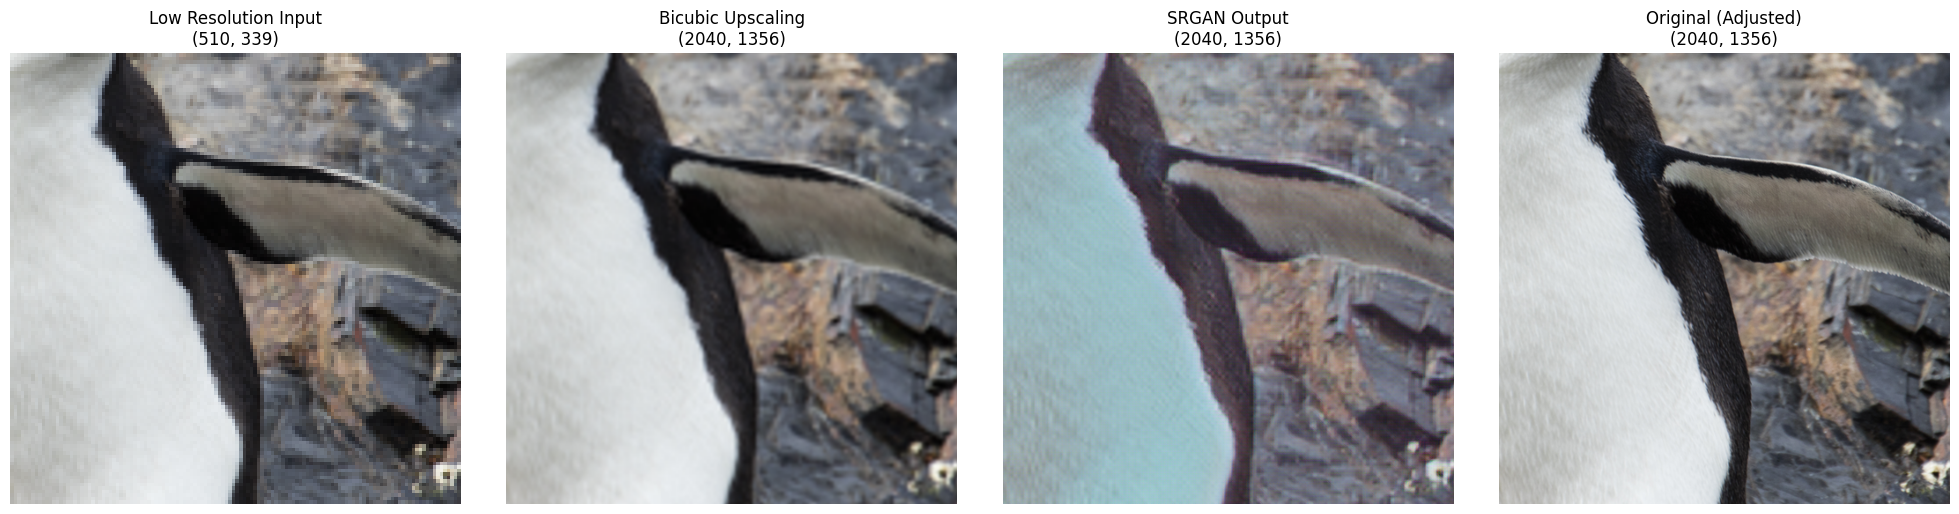

=== Results at Full Resolution ===
Image sizes: LR (510, 339) → SR (2040, 1356) vs Original (2040, 1356)
SRGAN vs Original:
  PSNR: 19.94 dB
  SSIM: 0.7524

Bicubic vs Original:
  PSNR: 27.63 dB
  SSIM: 0.8014

Improvement:
  PSNR: +-7.68 dB
  SSIM: +-0.0490


In [ ]:
# Test at full resolution
test_image_path = f"{TEST_DIR}/0801.png"
lr_img, bicubic_img, sr_img, original_img = test_original_full_resolution(test_image_path, "full_res_test_1")

# Calculate metrics
sr_numpy = np.array(sr_img)
original_numpy = np.array(original_img)
bicubic_numpy = np.array(bicubic_img)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Results at Full Resolution ===")
print(f"Image sizes: LR {lr_img.size} → SR {sr_img.size} vs Original {original_img.size}")
print(f"SRGAN vs Original:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Original:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")

Original image size: 2040 x 1464
LR input size: 510 x 366
Expected SR output size: 2040 x 1464
Generating super-resolution image...
SR tensor shape: torch.Size([1, 3, 1464, 2040])
Final SR image size: (2040, 1464)


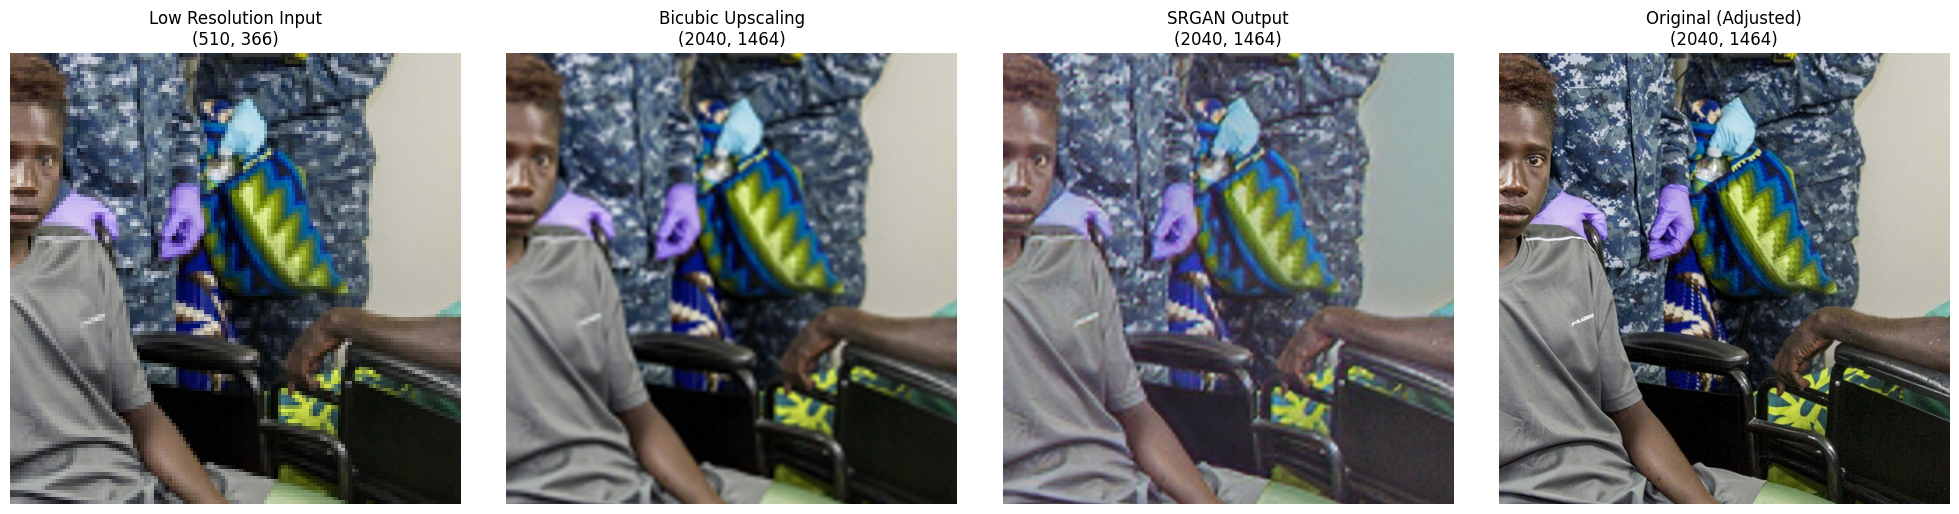

=== Results at Full Resolution ===
Image sizes: LR (510, 366) → SR (2040, 1464) vs Original (2040, 1464)
SRGAN vs Original:
  PSNR: 17.39 dB
  SSIM: 0.7379

Bicubic vs Original:
  PSNR: 28.84 dB
  SSIM: 0.8462

Improvement:
  PSNR: +-11.45 dB
  SSIM: +-0.1083


In [ ]:
# Test at full resolution
test_image_path = f"{TEST_DIR}/0813.png"
lr_img, bicubic_img, sr_img, original_img = test_original_full_resolution(test_image_path, "full_res_test_2")

# Calculate metrics
sr_numpy = np.array(sr_img)
original_numpy = np.array(original_img)
bicubic_numpy = np.array(bicubic_img)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Results at Full Resolution ===")
print(f"Image sizes: LR {lr_img.size} → SR {sr_img.size} vs Original {original_img.size}")
print(f"SRGAN vs Original:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Original:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")

Original image size: 2040 x 1536
LR input size: 510 x 384
Expected SR output size: 2040 x 1536
Generating super-resolution image...
SR tensor shape: torch.Size([1, 3, 1536, 2040])
Final SR image size: (2040, 1536)


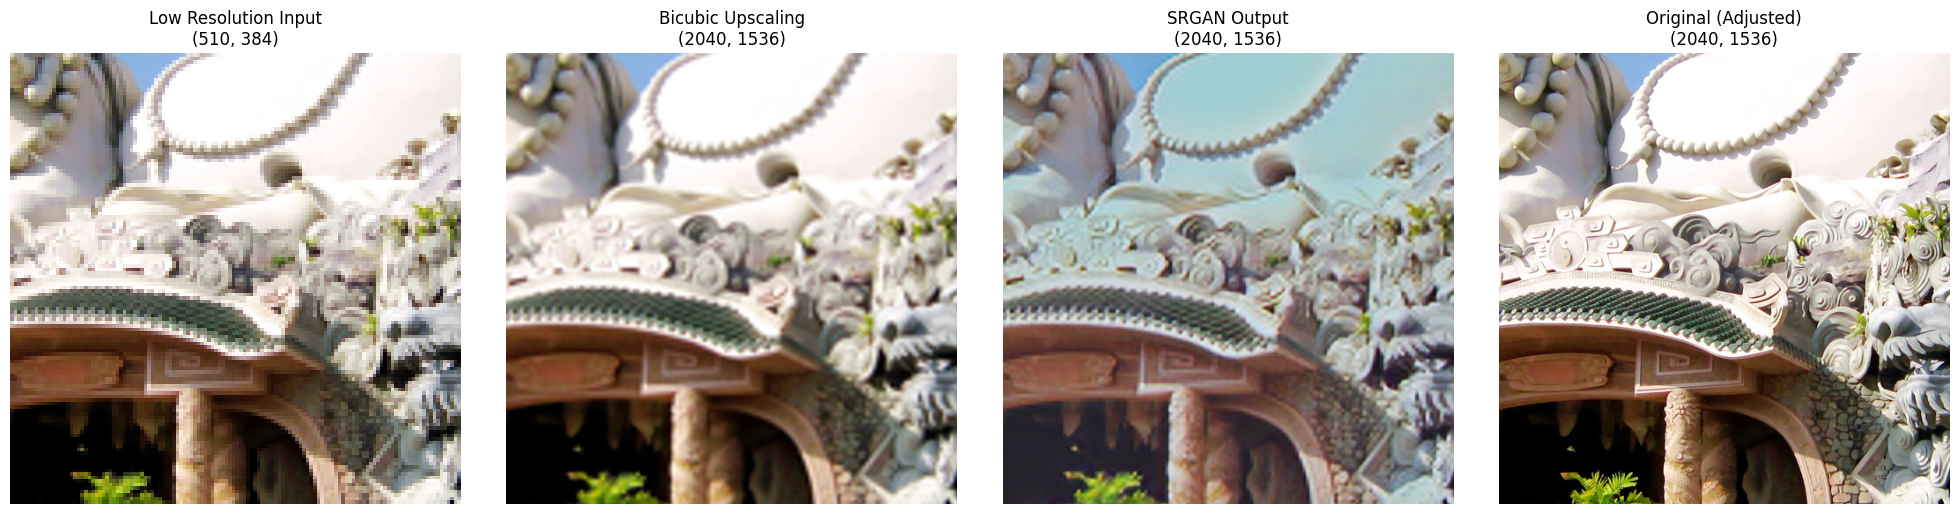

=== Results at Full Resolution ===
Image sizes: LR (510, 384) → SR (2040, 1536) vs Original (2040, 1536)
SRGAN vs Original:
  PSNR: 17.83 dB
  SSIM: 0.7747

Bicubic vs Original:
  PSNR: 26.57 dB
  SSIM: 0.8587

Improvement:
  PSNR: +-8.74 dB
  SSIM: +-0.0840


In [ ]:
# Test at full resolution
test_image_path = f"{TEST_DIR}/0818.png"
lr_img, bicubic_img, sr_img, original_img = test_original_full_resolution(test_image_path, "full_res_test_3")

# Calculate metrics
sr_numpy = np.array(sr_img)
original_numpy = np.array(original_img)
bicubic_numpy = np.array(bicubic_img)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Results at Full Resolution ===")
print(f"Image sizes: LR {lr_img.size} → SR {sr_img.size} vs Original {original_img.size}")
print(f"SRGAN vs Original:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Original:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")

In [21]:
import shutil

# Zip the results folder
shutil.make_archive("results", "zip", "results")
print("results.zip created. You can download it from the files pane.")

results.zip created. You can download it from the files pane.
